In [4]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Initialize Network ---
network = pypsa.Network()

# Snapshots: Hourly for 1 day (24 hours)
network.set_snapshots(pd.date_range("2022-01-01", periods=24, freq="H"))

# --- Add Components ---

# 1. Bus (Electricity Grid)
network.add("Bus", "electricity_bus")

# 2. Load (Time-varying demand)
base_load = 500  # MW
load_variability = 200 * np.sin(np.linspace(0, 2 * np.pi, 24))  # Daily sinusoidal pattern
network.add("Load", "electricity_demand", 
            bus="electricity_bus", 
            p_set=base_load + load_variability)

# 3. Generators (Renewables + Backup)

# Solar PV (Zero marginal cost, capacity factor 0-100%)
solar_capacity = 600  # MW
solar_profile = np.maximum(0, 0.7 * np.sin(np.linspace(-np.pi/2, 3*np.pi/2, 24)))  # Daylight hours
network.add("Generator", "solar_pv", 
            bus="electricity_bus",
            p_nom=solar_capacity,
            p_max_pu=solar_profile,
            marginal_cost=0,  # €/MWh
            capital_cost=500,  # €/MW
            efficiency=0.95)   # 5% losses

# Wind Turbine (Capacity factor 30-90%)
wind_capacity = 800  # MW
wind_profile = 0.6 + 0.3 * np.cos(np.linspace(0, 2*np.pi, 24))
network.add("Generator", "wind_turbine", 
            bus="electricity_bus",
            p_nom=wind_capacity,
            p_max_pu=wind_profile,
            marginal_cost=0,
            capital_cost=900,
            efficiency=0.98)

# Gas Peaker (Backup, high marginal cost)
network.add("Generator", "gas_peaker", 
            bus="electricity_bus",
            p_nom=1000,  # MW
            marginal_cost=50,  # €/MWh
            capital_cost=200,
            efficiency=0.4)

# 4. Battery Storage (4-hour duration)
battery_capacity = 400  # MW
network.add("StorageUnit", "battery", 
            bus="electricity_bus",
            p_nom=battery_capacity,
            max_hours=4,  # 4h storage
            efficiency_store=0.92,  # Charge efficiency
            efficiency_dispatch=0.92,  # Discharge efficiency
            marginal_cost=0.02,  # €/MWh
            capital_cost=1200)  # €/MW

# --- Solve Optimization ---
try:
    network.optimize(solver_name="glpk")  # Use GLPK (open-source)
except:
    print("GLPK failed, falling back to default solver...")
    network.optimize()  # Fallback to any installed solver

# --- Results Analysis ---
print("\n--- Objective Value (Total Cost) ---")
print(f"{network.objective:.2f} €")

print("\n--- Generator Dispatch (MW) ---")
print(network.generators_t.p.round(2))

print("\n--- Storage Activity (MW) ---")
print(network.storage_units_t.p.round(2))

print("\n--- State of Charge (MWh) ---")
print(network.storage_units_t.state_of_charge.round(2))

# --- Advanced Visualization ---
plt.style.use("seaborn")

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# 1. Demand vs. Generation
network.loads_t.p_set.plot(ax=ax1, label="Demand", linewidth=2, color="black")
network.generators_t.p.plot.area(ax=ax1, alpha=0.7)
ax1.set_ylabel("Power [MW]")
ax1.set_title("Electricity Demand vs. Generation")
ax1.legend(loc="upper left")
ax1.grid(True)

# 2. Storage Activity
network.storage_units_t.p.plot(ax=ax2, linewidth=2)
ax2.axhline(0, color="gray", linestyle="--")
ax2.set_ylabel("Power [MW]")
ax2.set_title("Battery Charge/Discharge")
ax2.grid(True)

# 3. State of Charge
network.storage_units_t.state_of_charge.plot(ax=ax3, linewidth=2, color="green")
ax3.set_ylabel("Energy [MWh]")
ax3.set_title("Battery State of Charge")
ax3.grid(True)

# Format x-axis
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xlabel("Time")
plt.tight_layout()
plt.show()

C:\Users\fardo\AppData\Local\Temp\ipykernel_24980\4001042042.py:11: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

Index(['electricity_bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Glpk solver
Index(['electricity_bus'], dtype='object', name='Bus')


GLPK failed, falling back to default solver...


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.11s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 144 primals, 336 duals
Objective: 1.55e+04
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.



--- Objective Value (Total Cost) ---
15518.57 €

--- Generator Dispatch (MW) ---
Generator            solar_pv  wind_turbine  gas_peaker
snapshot                                               
2022-01-01 00:00:00     -0.00        720.00       -0.00
2022-01-01 01:00:00     -0.00        711.10       -0.00
2022-01-01 02:00:00     -0.00        685.06       -0.00
2022-01-01 03:00:00     -0.00        643.81       -0.00
2022-01-01 04:00:00     -0.00        590.42       87.16
2022-01-01 05:00:00     -0.00        528.83        9.22
2022-01-01 06:00:00     28.66        463.62      207.25
2022-01-01 07:00:00    140.65        399.63       -0.00
2022-01-01 08:00:00    242.21        341.60       -0.00
2022-01-01 09:00:00    325.80        293.83        6.59
2022-01-01 10:00:00    319.81        259.87       -0.00
2022-01-01 11:00:00    285.00        242.24       -0.00
2022-01-01 12:00:00    230.53        242.24       -0.00
2022-01-01 13:00:00    160.45        259.87       -0.00
2022-01-01 14:00:00   

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

Index(['electricity_bus'], dtype='object', name='Bus')
Index(['solar_pv', 'wind_turbine', 'gas_peaker'], dtype='object', name='Generator')
INFO:linopy.model: Solve problem using Glpk solver
Index(['electricity_bus'], dtype='object', name='Bus')
Index(['solar_pv', 'wind_turbine', 'gas_peaker'], dtype='object', name='Generator')


GLPK failed, falling back to default solver...


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.09s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 144 primals, 336 duals
Objective: 1.55e+04
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.



--- Objective Value (Total Cost) ---
15518.57 €

--- Generator Dispatch (MW) ---
Generator            solar_pv  wind_turbine  gas_peaker
snapshot                                               
2022-01-01 00:00:00     -0.00        720.00       -0.00
2022-01-01 01:00:00     -0.00        711.10       -0.00
2022-01-01 02:00:00     -0.00        685.06       -0.00
2022-01-01 03:00:00     -0.00        643.81       -0.00
2022-01-01 04:00:00     -0.00        590.42       87.16
2022-01-01 05:00:00     -0.00        528.83        9.22
2022-01-01 06:00:00     28.66        463.62      207.25
2022-01-01 07:00:00    140.65        399.63       -0.00
2022-01-01 08:00:00    242.21        341.60       -0.00
2022-01-01 09:00:00    325.80        293.83        6.59
2022-01-01 10:00:00    319.81        259.87       -0.00
2022-01-01 11:00:00    285.00        242.24       -0.00
2022-01-01 12:00:00    230.53        242.24       -0.00
2022-01-01 13:00:00    160.45        259.87       -0.00
2022-01-01 14:00:00   

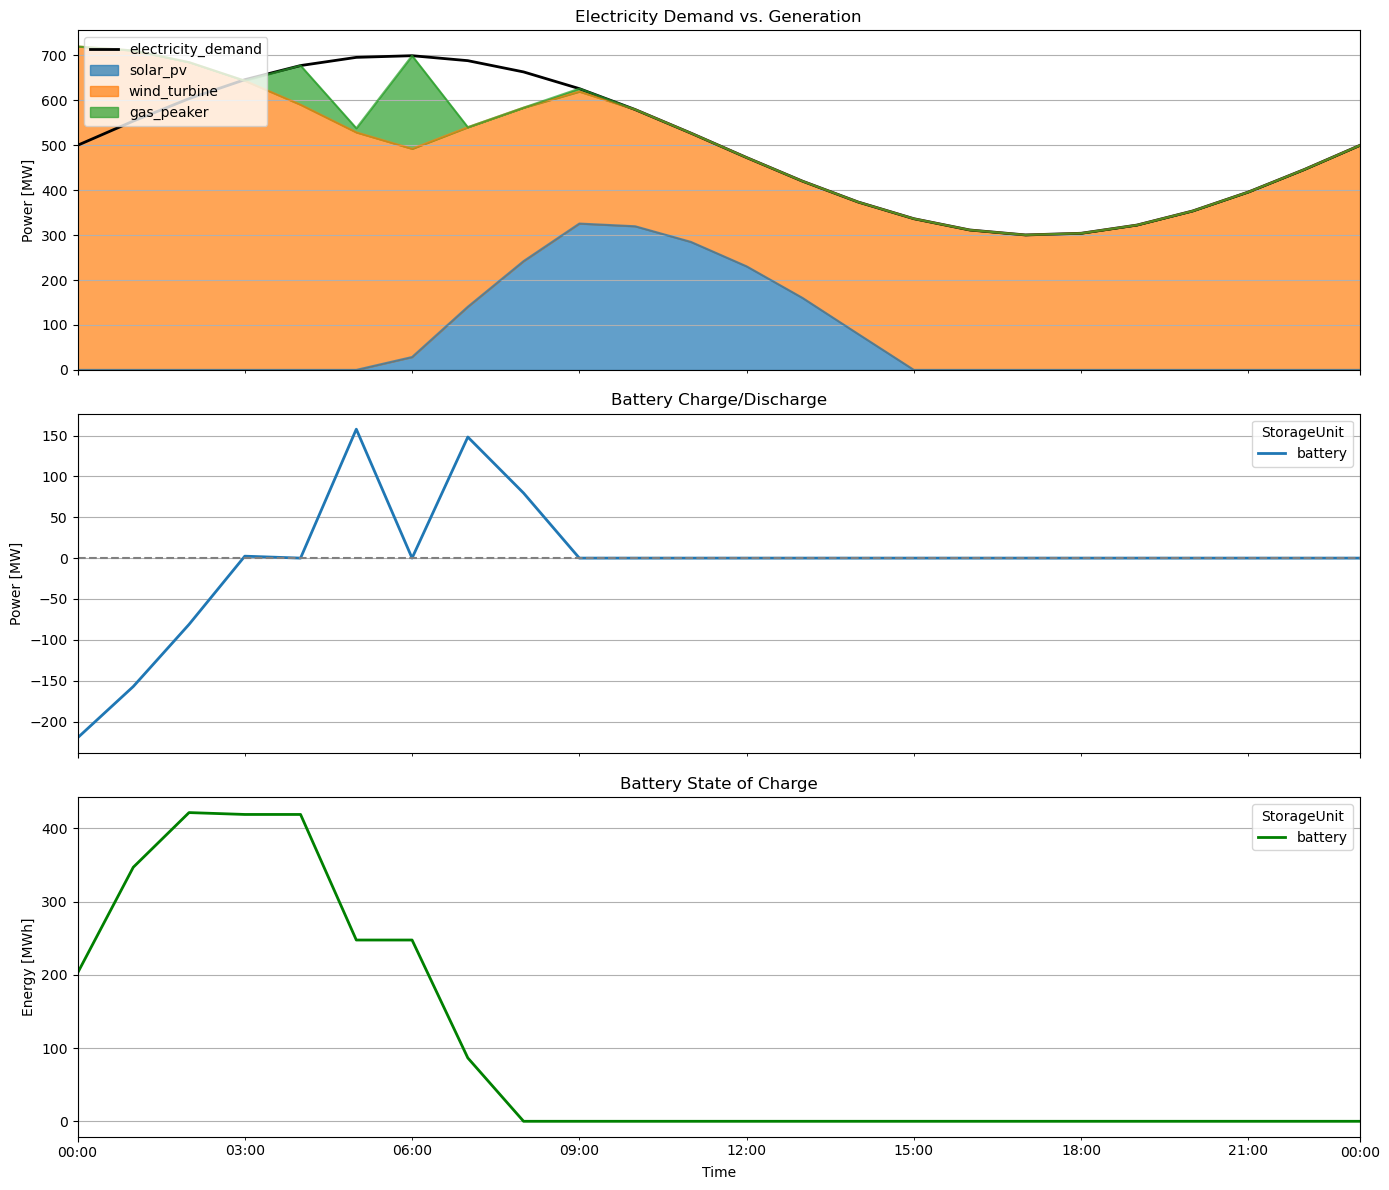

In [5]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Initialize Network ---
network = pypsa.Network()

# Snapshots: Hourly for 1 day (24 hours) - Use 'h' instead of 'H'
network.set_snapshots(pd.date_range("2022-01-01", periods=24, freq="h"))

# --- Add Components ---

# 1. Bus (Electricity Grid) - Define carrier to avoid warning
network.add("Bus", "electricity_bus", carrier="AC")

# 2. Load (Time-varying demand)
base_load = 500  # MW
load_variability = 200 * np.sin(np.linspace(0, 2 * np.pi, 24))  # Daily sinusoidal pattern
network.add("Load", "electricity_demand", 
            bus="electricity_bus", 
            p_set=base_load + load_variability)

# 3. Generators (Renewables + Backup)

# Solar PV (Zero marginal cost, capacity factor 0-100%)
solar_capacity = 600  # MW
solar_profile = np.maximum(0, 0.7 * np.sin(np.linspace(-np.pi/2, 3*np.pi/2, 24)))  # Daylight hours
network.add("Generator", "solar_pv", 
            bus="electricity_bus",
            p_nom=solar_capacity,
            p_max_pu=solar_profile,
            marginal_cost=0,  # €/MWh
            capital_cost=500,  # €/MW
            carrier="solar",
            efficiency=0.95)   # 5% losses

# Wind Turbine (Capacity factor 30-90%)
wind_capacity = 800  # MW
wind_profile = 0.6 + 0.3 * np.cos(np.linspace(0, 2*np.pi, 24))
network.add("Generator", "wind_turbine", 
            bus="electricity_bus",
            p_nom=wind_capacity,
            p_max_pu=wind_profile,
            marginal_cost=0,
            capital_cost=900,
            carrier="wind",
            efficiency=0.98)

# Gas Peaker (Backup, high marginal cost)
network.add("Generator", "gas_peaker", 
            bus="electricity_bus",
            p_nom=1000,  # MW
            marginal_cost=50,  # €/MWh
            capital_cost=200,
            carrier="gas",
            efficiency=0.4)

# 4. Battery Storage (4-hour duration)
battery_capacity = 400  # MW
network.add("StorageUnit", "battery", 
            bus="electricity_bus",
            p_nom=battery_capacity,
            max_hours=4,  # 4h storage
            efficiency_store=0.92,  # Charge efficiency
            efficiency_dispatch=0.92,  # Discharge efficiency
            marginal_cost=0.02,  # €/MWh
            capital_cost=1200)  # €/MW

# --- Solve Optimization ---
try:
    network.optimize(solver_name="glpk")  # Use GLPK (open-source)
except:
    print("GLPK failed, falling back to default solver...")
    network.optimize()  # Fallback to any installed solver

# --- Results Analysis ---
print("\n--- Objective Value (Total Cost) ---")
print(f"{network.objective:.2f} €")

print("\n--- Generator Dispatch (MW) ---")
print(network.generators_t.p.round(2))

print("\n--- Storage Activity (MW) ---")
print(network.storage_units_t.p.round(2))

print("\n--- State of Charge (MWh) ---")
print(network.storage_units_t.state_of_charge.round(2))

# --- Advanced Visualization ---
plt.style.use("default")  # Replace "seaborn" with "default" or install seaborn
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# 1. Demand vs. Generation
network.loads_t.p_set.plot(ax=ax1, label="Demand", linewidth=2, color="black")
network.generators_t.p.plot.area(ax=ax1, alpha=0.7)
ax1.set_ylabel("Power [MW]")
ax1.set_title("Electricity Demand vs. Generation")
ax1.legend(loc="upper left")
ax1.grid(True)

# 2. Storage Activity
network.storage_units_t.p.plot(ax=ax2, linewidth=2)
ax2.axhline(0, color="gray", linestyle="--")
ax2.set_ylabel("Power [MW]")
ax2.set_title("Battery Charge/Discharge")
ax2.grid(True)

# 3. State of Charge
network.storage_units_t.state_of_charge.plot(ax=ax3, linewidth=2, color="green")
ax3.set_ylabel("Energy [MWh]")
ax3.set_title("Battery State of Charge")
ax3.grid(True)

# Format x-axis
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xlabel("Time")
plt.tight_layout()
plt.show()